# FCN
This notebook contains a test CNN in pytorch, to get familiar with this developping environment. It also acts as a template for later use.

In [1]:
%matplotlib inline
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import os,sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time

#seed for reproducible results
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

## Pytorch module

This module contains the FCN based on the CNN module

### Module structure

For this module, we will try to implement the complex diagram describe in http://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w4/Zhou_D-LinkNet_LinkNet_With_CVPR_2018_paper.pdf

Usefull links:

-Torch documentations (especially for the input/ouput size of Conv2d and ConvTranspose2d: https://pytorch.org/docs/stable/nn.html

-This link to better understand what each argument in Conv2d and ConvTranspose2d: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [3]:
# This class takes our input of size 400*400 and enlarges it to size 512*512

class FCN_DLinkNet(torch.nn.Module):
        
    def __init__(self):
        super(FCN_DLinkNet, self).__init__()
        
        # Encoding part
        
        self.convstart = torch.nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=58)
        self.pool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.convEncodBlock1 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.convEncodBlock2start = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.convEncodBlock2 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.convEncodBlock3start = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.convEncodBlock3 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.convEncodBlock4start = torch.nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.convEncodBlock4 = torch.nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        # Center part
        
        self.convCenterdil1 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1) #same as convEncodBlock4 but added for clarity
        self.convCenterdil2 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.convCenterdil4 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=4, dilation=4)
        self.convCenterdil8 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=8, dilation=8)
        
        # Decoding part
        
        self.convDecodBlock4start = torch.nn.Conv2d(512, 128, kernel_size=1)
        self.deconvDecodBlock4 = torch.nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convDecodBlock4end = torch.nn.Conv2d(128, 256, kernel_size=1)
        
        self.convDecodBlock3start = torch.nn.Conv2d(256, 64, kernel_size=1)
        self.deconvDecodBlock3 = torch.nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convDecodBlock3end = torch.nn.Conv2d(64, 128, kernel_size=1)
        
        self.convDecodBlock2start = torch.nn.Conv2d(128, 32, kernel_size=1)
        self.deconvDecodBlock2 = torch.nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convDecodBlock2end = torch.nn.Conv2d(32, 64, kernel_size=1)
        
        self.convDecodBlock1start = torch.nn.Conv2d(64, 16, kernel_size=1)
        self.deconvDecodBlock1 = torch.nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convDecodBlock1end = torch.nn.Conv2d(16, 64, kernel_size=1)
        
        self.deconvDecodend = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=57)
        self.convDecoddil1end = torch.nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1, dilation=1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        
        def codeBlock1(self, x):
            for i in range(0, 3):
                x_inter = F.relu(self.convEncodBlock1(x))
                x_inter = F.relu(self.convEncodBlock1(x_inter))
                # Moyenne
                x = (x + x_inter)/2
            return x

        def codeBlock2(self, x):
            x = self.pool(x)
            x_inter = F.relu(self.convEncodBlock2start(x))
            x_inter = F.relu(self.convEncodBlock2(x_inter))
            new_x = torch.zeros(x_inter.shape)
            new_x[:, :64, :, :] = x
            # Moyenne
            x = (new_x + x_inter)/2
            for i in range(0, 3):
                x_inter = F.relu(self.convEncodBlock2(x))
                x_inter = F.relu(self.convEncodBlock2(x_inter))
                # Moyenne
                x = (x + x_inter)/2
            return x

        def codeBlock3(self, x):
            x = self.pool(x)
            x_inter = F.relu(self.convEncodBlock3start(x))
            x_inter = F.relu(self.convEncodBlock3(x_inter))
            new_x = torch.zeros(x_inter.shape)
            new_x[:, :128, :, :] = x
            # Moyenne
            x = (new_x + x_inter)/2
            for i in range(0, 5):
                x_inter = F.relu(self.convEncodBlock3(x))
                x_inter = F.relu(self.convEncodBlock3(x_inter))
                # Moyenne
                x = (x + x_inter)/2
            return x

        def codeBlock4(self, x):
            x = self.pool(x)
            x_inter = F.relu(self.convEncodBlock4start(x))
            x_inter = F.relu(self.convEncodBlock4(x_inter))
            new_x = torch.zeros(x_inter.shape)
            new_x[:, :256, :, :] = x
            # Moyenne
            x = (new_x + x_inter)/2
            for i in range(0, 2):
                x_inter = F.relu(self.convEncodBlock4(x))
                x_inter = F.relu(self.convEncodBlock4(x_inter))
                # Moyenne
                x = (x + x_inter)/2
            return x

        def decodeBlock4(self, x):
            x = F.relu(self.convDecodBlock4start(x))
            x = self.deconvDecodBlock4(x)
            x = F.relu(self.convDecodBlock4end(x))
            return x

        def decodeBlock3(self, x):
            x = F.relu(self.convDecodBlock3start(x))
            x = self.deconvDecodBlock3(x)
            x = F.relu(self.convDecodBlock3end(x))
            return x

        def decodeBlock2(self, x):
            x = F.relu(self.convDecodBlock2start(x))
            x = self.deconvDecodBlock2(x)
            x = F.relu(self.convDecodBlock2end(x))
            return x

        def decodeBlock1(self, x):
            x = F.relu(self.convDecodBlock1start(x))
            x = self.deconvDecodBlock1(x)
            x = F.relu(self.convDecodBlock1end(x))
            return x
        
        x_start = F.relu(self.convstart(x))
        x_start = self.pool(x_start)
        
        x_codeBlock1 = codeBlock1(self, x_start)
        x_codeBlock2 = codeBlock2(self, x_codeBlock1)
        x_codeBlock3 = codeBlock3(self, x_codeBlock2)
        x_codeBlock4 = codeBlock4(self, x_codeBlock3)
        
        x_center1 = F.relu(self.convCenterdil1(x_codeBlock4))
        x_center2 = F.relu(self.convCenterdil2(x_center1))
        x_center3 = F.relu(self.convCenterdil4(x_center2))
        x_center4 = F.relu(self.convCenterdil8(x_center3))
        
        x_center_final = (x_codeBlock4 + x_center1 + x_center2 + x_center3 + x_center4)/5
        
        x_decodeBlock4 = decodeBlock4(self, x_center_final)
        x_decodeBlock3 = decodeBlock3(self, (x_decodeBlock4 + x_codeBlock3)/2)
        x_decodeBlock2 = decodeBlock2(self, (x_decodeBlock3 + x_codeBlock2)/2)
        x_decodeBlock1 = decodeBlock1(self, (x_decodeBlock2 + x_codeBlock1)/2)
        
        x_end = self.deconvDecodend(x_decodeBlock1)
        x_end = F.relu(self.convDecoddil1end(x_end))
        x_end = self.sigmoid(x_end)
        
        return(x_end)

In [4]:
# This class takes our input of size 400*400 and directly put it to size 256*256

class FCN_DLinkNet_new(torch.nn.Module):
        
    def __init__(self):
        super(FCN_DLinkNet_new, self).__init__()
        
        # Encoding part
        
        self.convstart = torch.nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=57)
        self.pool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.convEncodBlock1 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.convEncodBlock2start = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.convEncodBlock2 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.convEncodBlock3start = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.convEncodBlock3 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.convEncodBlock4start = torch.nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.convEncodBlock4 = torch.nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        # Center part
        
        self.convCenterdil1 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1) #same as convEncodBlock4 but added for clarity
        self.convCenterdil2 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.convCenterdil4 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=4, dilation=4)
        self.convCenterdil8 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=8, dilation=8)
        
        # Decoding part
        
        self.convDecodBlock4start = torch.nn.Conv2d(512, 128, kernel_size=1)
        self.deconvDecodBlock4 = torch.nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convDecodBlock4end = torch.nn.Conv2d(128, 256, kernel_size=1)
        
        self.convDecodBlock3start = torch.nn.Conv2d(256, 64, kernel_size=1)
        self.deconvDecodBlock3 = torch.nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convDecodBlock3end = torch.nn.Conv2d(64, 128, kernel_size=1)
        
        self.convDecodBlock2start = torch.nn.Conv2d(128, 32, kernel_size=1)
        self.deconvDecodBlock2 = torch.nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convDecodBlock2end = torch.nn.Conv2d(32, 64, kernel_size=1)
        
        self.convDecodBlock1start = torch.nn.Conv2d(64, 16, kernel_size=1)
        self.deconvDecodBlock1 = torch.nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convDecodBlock1end = torch.nn.Conv2d(16, 64, kernel_size=1)
        
        self.deconvDecodend = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=57)
        self.convDecoddil1end = torch.nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1, dilation=1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        
        def codeBlock1(self, x):
            for i in range(0, 3):
                x_inter = F.relu(self.convEncodBlock1(x))
                x_inter = F.relu(self.convEncodBlock1(x_inter))
                # Moyenne
                x = x + x_inter
            return x

        def codeBlock2(self, x):
            x = self.pool(x)
            x_inter = F.relu(self.convEncodBlock2start(x))
            x_inter = F.relu(self.convEncodBlock2(x_inter))
            new_x = torch.zeros(x_inter.shape)
            new_x[:, :64, :, :] = x
            # Moyenne
            x = new_x + x_inter
            for i in range(0, 3):
                x_inter = F.relu(self.convEncodBlock2(x))
                x_inter = F.relu(self.convEncodBlock2(x_inter))
                # Moyenne
                x = x + x_inter
            return x

        def codeBlock3(self, x):
            x = self.pool(x)
            x_inter = F.relu(self.convEncodBlock3start(x))
            x_inter = F.relu(self.convEncodBlock3(x_inter))
            new_x = torch.zeros(x_inter.shape)
            new_x[:, :128, :, :] = x
            # Moyenne
            x = new_x + x_inter
            for i in range(0, 5):
                x_inter = F.relu(self.convEncodBlock3(x))
                x_inter = F.relu(self.convEncodBlock3(x_inter))
                # Moyenne
                x = x + x_inter
            return x

        def codeBlock4(self, x):
            x = self.pool(x)
            x_inter = F.relu(self.convEncodBlock4start(x))
            x_inter = F.relu(self.convEncodBlock4(x_inter))
            new_x = torch.zeros(x_inter.shape)
            new_x[:, :256, :, :] = x
            # Moyenne
            x = new_x + x_inter
            for i in range(0, 2):
                x_inter = F.relu(self.convEncodBlock4(x))
                x_inter = F.relu(self.convEncodBlock4(x_inter))
                # Moyenne
                x = x + x_inter
            return x

        def decodeBlock4(self, x):
            x = F.relu(self.convDecodBlock4start(x))
            x = self.deconvDecodBlock4(x)
            x = F.relu(self.convDecodBlock4end(x))
            return x

        def decodeBlock3(self, x):
            x = F.relu(self.convDecodBlock3start(x))
            x = self.deconvDecodBlock3(x)
            x = F.relu(self.convDecodBlock3end(x))
            return x

        def decodeBlock2(self, x):
            x = F.relu(self.convDecodBlock2start(x))
            x = self.deconvDecodBlock2(x)
            x = F.relu(self.convDecodBlock2end(x))
            return x

        def decodeBlock1(self, x):
            x = F.relu(self.convDecodBlock1start(x))
            x = self.deconvDecodBlock1(x)
            x = F.relu(self.convDecodBlock1end(x))
            return x
        
        x_start = F.relu(self.convstart(x))
        
        x_codeBlock1 = codeBlock1(self, x_start)
        x_codeBlock2 = codeBlock2(self, x_codeBlock1)
        x_codeBlock3 = codeBlock3(self, x_codeBlock2)
        x_codeBlock4 = codeBlock4(self, x_codeBlock3)
        
        x_center1 = F.relu(self.convCenterdil1(x_codeBlock4))
        x_center2 = F.relu(self.convCenterdil2(x_center1))
        x_center3 = F.relu(self.convCenterdil4(x_center2))
        x_center4 = F.relu(self.convCenterdil8(x_center3))
        
        x_center_final = x_codeBlock4 + x_center1 + x_center2 + x_center3 + x_center4
        
        x_decodeBlock4 = decodeBlock4(self, x_center_final)
        x_decodeBlock3 = decodeBlock3(self, x_decodeBlock4 + x_codeBlock3)
        x_decodeBlock2 = decodeBlock2(self, x_decodeBlock3 + x_codeBlock2)
        x_decodeBlock1 = decodeBlock1(self, x_decodeBlock2 + x_codeBlock1)
        
        x_end = self.deconvDecodend(x_decodeBlock1)
        x_end = F.relu(self.convDecoddil1end(x_end))
        x_end = self.sigmoid(x_end)
        
        return(x_end)

This model optimized with adam and cross entropy will converge to all-black images every time

## Training the model

In [5]:
# Loading a set of 100 training images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = np.array([load_image(image_dir + files[i]) for i in range(n)]).swapaxes(1,3).swapaxes(2,3)
print(np.shape(imgs))

train_input = imgs[0:12] #normally = 0:90
validation_input = imgs[12:15] #normally = 90:100

image_dir = root_dir + "groundtruth/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(np.shape(imgs))

train_target = imgs[0:12] #normally = 0:90
validation_target = imgs[12:15] #normally = 90:100

Loading 100 images
(100, 3, 400, 400)
Loading 100 images
(100, 400, 400)


We will keep 10 images from this set as a validation set.
To shorten the computationnal time we will use a smaller amount of images to do tests.

### Instantiate the model, loss function and optimizer

In [6]:
# We will optimize the cross-entropy loss using adam algorithm
net = FCN_DLinkNet_new()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
def trainNet(net, n_epochs):
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        total_loss = 0.0
        
        for index in range(np.shape(train_input)[0]):
            
            input_image = Variable(torch.tensor(train_input[index], requires_grad=True).unsqueeze(0))
            target_image = Variable(torch.tensor(train_target[index], dtype=torch.long).unsqueeze(0))
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(input_image)
            loss = loss_function(outputs, target_image)
            loss.backward()
            optimizer.step()
            
            #Print statistics
            total_loss += loss.item()
            
            print("Epoch", epoch, ", image", index, ", image loss:", loss.item(), ", time elapsed:", time.time() - training_start_time)
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for index in range(np.shape(validation_input)[0]):
            
            input_image = Variable(torch.tensor(validation_input[index], requires_grad=True).unsqueeze(0))
            target_image = Variable(torch.tensor(validation_target[index], dtype=torch.long).unsqueeze(0))
            
            #Forward pass
            val_outputs = net(input_image)
            val_loss = loss_function(val_outputs, target_image)
            total_val_loss += val_loss.item()
            
        print("Validation loss for epoch", epoch, ":", total_val_loss/np.shape(validation_input)[0])
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [8]:
trainNet(net, 1)

Epoch 0 , image 0 , image loss: 0.6935377717018127 , time elapsed: 10.525941848754883
Epoch 0 , image 1 , image loss: 0.6874483823776245 , time elapsed: 20.921140909194946
Epoch 0 , image 2 , image loss: 0.6776967644691467 , time elapsed: 32.44532036781311
Epoch 0 , image 3 , image loss: 0.6640986204147339 , time elapsed: 44.23080039024353
Epoch 0 , image 4 , image loss: 0.6458911895751953 , time elapsed: 55.71009969711304
Epoch 0 , image 5 , image loss: 0.47793036699295044 , time elapsed: 68.00920701026917
Epoch 0 , image 6 , image loss: 0.47387319803237915 , time elapsed: 80.28736996650696
Epoch 0 , image 7 , image loss: 0.4738675355911255 , time elapsed: 91.32983684539795
Epoch 0 , image 8 , image loss: 0.4738675355911255 , time elapsed: 103.56611180305481
Epoch 0 , image 9 , image loss: 0.4738675355911255 , time elapsed: 114.29142737388611
Epoch 0 , image 10 , image loss: 0.4738675355911255 , time elapsed: 125.94027280807495
Epoch 0 , image 11 , image loss: 0.4738675355911255 , tim

In [9]:
input_image = torch.tensor(validation_input[0]).unsqueeze(0)
target_image = torch.tensor(validation_target[0]).unsqueeze(0)
           
#Forward pass
val_output = net(input_image)
output_image = val_output[0,1]

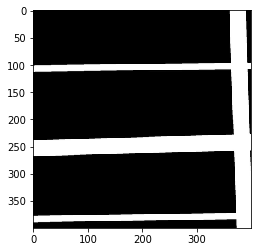

In [10]:
plt.imshow(target_image.squeeze(0), cmap='Greys_r')

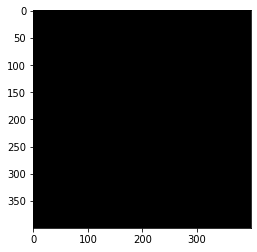

In [11]:
plt.imshow(output_image.detach().numpy(), cmap='Greys_r')